In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-06 14:58:33,434] A new study created in memory with name: no-name-0dd02224-d5c9-46da-87b2-87571cba63c1
[I 2025-06-06 15:00:37,700] Trial 0 finished with value: 19.46202144622803 and parameters: {'lr': 0.4586018863926747, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.340973255958303}. Best is trial 0 with value: 19.46202144622803.


Cross Validation Accuracies:
[18.22868537902832, 25.040977478027344, 13.175895690917969, 12.934317588806152, 27.93023109436035]
Mean Cross Validation Accuracy:
19.46202144622803
Standard Deviation of Cross Validation Accuracy:
6.1070899381931465


[I 2025-06-06 15:02:27,201] Trial 1 finished with value: 0.08363801538944245 and parameters: {'lr': 0.05376344302145848, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.16860157884145127}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.140933096408844, 0.12093651294708252, 0.07283373922109604, 0.06731338798999786, 0.016173340380191803]
Mean Cross Validation Accuracy:
0.08363801538944245
Standard Deviation of Cross Validation Accuracy:
0.0438374553240342


[I 2025-06-06 15:03:56,439] Trial 2 finished with value: 0.09926974177360534 and parameters: {'lr': 0.007223262499554175, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3308450190506833}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.09203243255615234, 0.13291336596012115, 0.07280725240707397, 0.14534445106983185, 0.05325120687484741]
Mean Cross Validation Accuracy:
0.09926974177360534
Standard Deviation of Cross Validation Accuracy:
0.03500034236274357


[I 2025-06-06 15:06:29,592] Trial 3 finished with value: 0.2131129428744316 and parameters: {'lr': 0.002421737301498728, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3463486708932192}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.25366276502609253, 0.23249413073062897, 0.111020527780056, 0.26699885725975037, 0.2013884335756302]
Mean Cross Validation Accuracy:
0.2131129428744316
Standard Deviation of Cross Validation Accuracy:
0.05564878368210831


[I 2025-06-06 15:08:10,030] Trial 4 finished with value: 0.09580470230430364 and parameters: {'lr': 0.00364681952171879, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26392436376173356}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.10287360846996307, 0.12623751163482666, 0.11687523871660233, 0.12001821398735046, 0.013018938712775707]
Mean Cross Validation Accuracy:
0.09580470230430364
Standard Deviation of Cross Validation Accuracy:
0.04209482064170429


[I 2025-06-06 15:11:06,971] Trial 5 finished with value: 0.1069216936826706 and parameters: {'lr': 0.004940974908678448, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.19065747392562502}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.1905284970998764, 0.1306014358997345, 0.05236640200018883, 0.12438514828681946, 0.03672698512673378]
Mean Cross Validation Accuracy:
0.1069216936826706
Standard Deviation of Cross Validation Accuracy:
0.05614156566330269


[I 2025-06-06 15:12:29,134] Trial 6 finished with value: 0.11835944280028343 and parameters: {'lr': 0.007637536862759249, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16837215691260132}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.037963319569826126, 0.14859993755817413, 0.09763487428426743, 0.23087309300899506, 0.07672598958015442]
Mean Cross Validation Accuracy:
0.11835944280028343
Standard Deviation of Cross Validation Accuracy:
0.06663362184991135


[I 2025-06-06 15:13:57,100] Trial 7 finished with value: 0.4863739967346191 and parameters: {'lr': 0.028074650874305832, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.37965160199001}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.6353439688682556, 0.17349708080291748, 0.5684882998466492, 0.5210187435150146, 0.5335218906402588]
Mean Cross Validation Accuracy:
0.4863739967346191
Standard Deviation of Cross Validation Accuracy:
0.16140009806392255


[I 2025-06-06 15:15:29,084] Trial 8 finished with value: 0.11966084092855453 and parameters: {'lr': 0.7405344741519984, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.33336464618620454}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.20117978751659393, 0.13142114877700806, 0.07593157887458801, 0.12824426591396332, 0.061527423560619354]
Mean Cross Validation Accuracy:
0.11966084092855453
Standard Deviation of Cross Validation Accuracy:
0.049293125793873495


[I 2025-06-06 15:17:53,314] Trial 9 finished with value: 0.15198847651481628 and parameters: {'lr': 0.10512389092650805, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.34097464231655095}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.10382558405399323, 0.25647836923599243, 0.161051943898201, 0.10899855196475983, 0.12958793342113495]
Mean Cross Validation Accuracy:
0.15198847651481628
Standard Deviation of Cross Validation Accuracy:
0.05598190113920178


[I 2025-06-06 15:19:27,585] Trial 10 finished with value: 0.0963409997522831 and parameters: {'lr': 0.06893133178988835, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.47423730000519154}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.12156324833631516, 0.12140128761529922, 0.05583826079964638, 0.17366789281368256, 0.009234309196472168]
Mean Cross Validation Accuracy:
0.0963409997522831
Standard Deviation of Cross Validation Accuracy:
0.05739629891237289


[I 2025-06-06 15:20:48,864] Trial 11 finished with value: 0.12563762217760086 and parameters: {'lr': 0.001219191224480582, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.23370255838588275}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.1501680314540863, 0.15166938304901123, 0.07151550054550171, 0.11039146035909653, 0.14444373548030853]
Mean Cross Validation Accuracy:
0.12563762217760086
Standard Deviation of Cross Validation Accuracy:
0.030966798191121428


[I 2025-06-06 15:22:10,127] Trial 12 finished with value: 0.10298510640859604 and parameters: {'lr': 0.02364339739544347, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10252551425839634}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.0721692219376564, 0.1654447764158249, 0.05865773558616638, 0.12080961465835571, 0.0978441834449768]
Mean Cross Validation Accuracy:
0.10298510640859604
Standard Deviation of Cross Validation Accuracy:
0.037841477509291385


[I 2025-06-06 15:23:33,789] Trial 13 finished with value: 0.09972645938396454 and parameters: {'lr': 0.15026645706213906, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.23542929976972016}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.09390254318714142, 0.1233103796839714, 0.05288201570510864, 0.18107618391513824, 0.04746117442846298]
Mean Cross Validation Accuracy:
0.09972645938396454
Standard Deviation of Cross Validation Accuracy:
0.04926247840485458


[I 2025-06-06 15:25:03,976] Trial 14 finished with value: 0.11985234320163726 and parameters: {'lr': 0.014004253243162231, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10792869965805019}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.14793987572193146, 0.12119587510824203, 0.0832613855600357, 0.17915089428424835, 0.06771368533372879]
Mean Cross Validation Accuracy:
0.11985234320163726
Standard Deviation of Cross Validation Accuracy:
0.040900783725879825


[I 2025-06-06 15:26:40,425] Trial 15 finished with value: 1.8717211723327636 and parameters: {'lr': 0.24345832904639347, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26743383334358234}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.9481119513511658, 4.08193826675415, 2.7443337440490723, 0.780249297618866, 0.803972601890564]
Mean Cross Validation Accuracy:
1.8717211723327636
Standard Deviation of Cross Validation Accuracy:
1.3289818780438605


[I 2025-06-06 15:28:11,741] Trial 16 finished with value: 0.10072999205440283 and parameters: {'lr': 0.05409195685396441, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17080252482757272}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.1365535706281662, 0.12141969799995422, 0.13856691122055054, 0.10187651962041855, 0.005233260802924633]
Mean Cross Validation Accuracy:
0.10072999205440283
Standard Deviation of Cross Validation Accuracy:
0.04952568095666381


[I 2025-06-06 15:29:28,886] Trial 17 finished with value: 0.0974951408803463 and parameters: {'lr': 0.0011725128433187418, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4064776015695883}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.10743921995162964, 0.12870420515537262, 0.0740070715546608, 0.12732937932014465, 0.04999582841992378]
Mean Cross Validation Accuracy:
0.0974951408803463
Standard Deviation of Cross Validation Accuracy:
0.030889630200578506


[I 2025-06-06 15:31:05,643] Trial 18 finished with value: 0.11860113628208638 and parameters: {'lr': 0.0036696392261408705, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.28086182970283186}. Best is trial 1 with value: 0.08363801538944245.


Cross Validation Accuracies:
[0.2164328545331955, 0.15247328579425812, 0.0523809976875782, 0.14399871230125427, 0.027719831094145775]
Mean Cross Validation Accuracy:
0.11860113628208638
Standard Deviation of Cross Validation Accuracy:
0.0692934670287585


[I 2025-06-06 15:33:39,777] Trial 19 finished with value: 0.0823930200189352 and parameters: {'lr': 0.015200391483463272, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2154691015631988}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.046787332743406296, 0.15564823150634766, 0.09014379233121872, 0.10042618960142136, 0.01895955391228199]
Mean Cross Validation Accuracy:
0.0823930200189352
Standard Deviation of Cross Validation Accuracy:
0.0469960961684261


[I 2025-06-06 15:36:12,622] Trial 20 finished with value: 0.11415911093354225 and parameters: {'lr': 0.014183905142356658, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14224954576535487}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.1398947685956955, 0.12996898591518402, 0.054305098950862885, 0.23673897981643677, 0.00988772138953209]
Mean Cross Validation Accuracy:
0.11415911093354225
Standard Deviation of Cross Validation Accuracy:
0.07796553841980153


[I 2025-06-06 15:38:43,734] Trial 21 finished with value: 0.12559934556484223 and parameters: {'lr': 0.015103000185336732, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2142652953837163}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.13183952867984772, 0.12369313836097717, 0.0871286392211914, 0.14053377509117126, 0.14480164647102356]
Mean Cross Validation Accuracy:
0.12559934556484223
Standard Deviation of Cross Validation Accuracy:
0.020563726817679245


[I 2025-06-06 15:41:17,703] Trial 22 finished with value: 0.2701155453920364 and parameters: {'lr': 0.04399741288342703, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.25223306507085286}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.07727429270744324, 0.12913839519023895, 0.9525737166404724, 0.12842154502868652, 0.06316977739334106]
Mean Cross Validation Accuracy:
0.2701155453920364
Standard Deviation of Cross Validation Accuracy:
0.3422616548055834


[I 2025-06-06 15:43:56,404] Trial 23 finished with value: 0.1528681293129921 and parameters: {'lr': 0.0023033401304801923, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21150562571129736}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.16082234680652618, 0.1632378101348877, 0.14154590666294098, 0.18376706540584564, 0.11496751755475998]
Mean Cross Validation Accuracy:
0.1528681293129921
Standard Deviation of Cross Validation Accuracy:
0.02319565996189052


[I 2025-06-06 15:45:44,693] Trial 24 finished with value: 0.48069382905960084 and parameters: {'lr': 0.007799164975646257, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2892192610318589}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.41273000836372375, 0.46850860118865967, 0.45487794280052185, 0.6174312829971313, 0.44992130994796753]
Mean Cross Validation Accuracy:
0.48069382905960084
Standard Deviation of Cross Validation Accuracy:
0.07082104196774276


[I 2025-06-06 15:47:51,070] Trial 25 finished with value: 0.35976924300193786 and parameters: {'lr': 0.019574620831560956, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16152749420372473}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.2647734582424164, 0.37555575370788574, 0.40271177887916565, 0.4586050510406494, 0.29720017313957214]
Mean Cross Validation Accuracy:
0.35976924300193786
Standard Deviation of Cross Validation Accuracy:
0.07042851678690952


[I 2025-06-06 15:49:15,193] Trial 26 finished with value: 0.10775276273488998 and parameters: {'lr': 0.08617515746794796, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.20028905318140058}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.10180943459272385, 0.12880034744739532, 0.0765579417347908, 0.1400851309299469, 0.09151095896959305]
Mean Cross Validation Accuracy:
0.10775276273488998
Standard Deviation of Cross Validation Accuracy:
0.02349731495943706


[I 2025-06-06 15:50:57,024] Trial 27 finished with value: 0.18554457128047944 and parameters: {'lr': 0.03628687151569168, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3017421042693908}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.08989054709672928, 0.1332513988018036, 0.3128034174442291, 0.12189070135354996, 0.2698867917060852]
Mean Cross Validation Accuracy:
0.18554457128047944
Standard Deviation of Cross Validation Accuracy:
0.08859402627757115


[I 2025-06-06 15:52:57,098] Trial 28 finished with value: 0.09986825436353683 and parameters: {'lr': 0.0021302949516562725, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1359899003123946}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.10435560345649719, 0.13154329359531403, 0.08617623895406723, 0.1279820203781128, 0.04928411543369293]
Mean Cross Validation Accuracy:
0.09986825436353683
Standard Deviation of Cross Validation Accuracy:
0.030199518701416236


[I 2025-06-06 15:55:47,385] Trial 29 finished with value: 22.82755069732666 and parameters: {'lr': 0.24344307750856276, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2364162674360783}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[14.505412101745605, 29.192825317382812, 20.153947830200195, 21.239566802978516, 29.046001434326172]
Mean Cross Validation Accuracy:
22.82755069732666
Standard Deviation of Cross Validation Accuracy:
5.6234097574531505


[I 2025-06-06 15:57:22,378] Trial 30 finished with value: 0.3109279364347458 and parameters: {'lr': 0.010613679432195903, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.30911201443491726}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.4227914810180664, 0.30589962005615234, 0.33396413922309875, 0.2223205715417862, 0.26966387033462524]
Mean Cross Validation Accuracy:
0.3109279364347458
Standard Deviation of Cross Validation Accuracy:
0.06726572897938908


[I 2025-06-06 15:58:40,461] Trial 31 finished with value: 0.13514893352985383 and parameters: {'lr': 0.06750558447285944, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.48745175731414475}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.13352206349372864, 0.15645001828670502, 0.10735860466957092, 0.14457154273986816, 0.13384243845939636]
Mean Cross Validation Accuracy:
0.13514893352985383
Standard Deviation of Cross Validation Accuracy:
0.016243015666984068


[I 2025-06-06 16:00:06,354] Trial 32 finished with value: 0.10365348011255264 and parameters: {'lr': 0.12795487881446457, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.471038299601461}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.0624285489320755, 0.12683413922786713, 0.12642474472522736, 0.06517673283815384, 0.1374032348394394]
Mean Cross Validation Accuracy:
0.10365348011255264
Standard Deviation of Cross Validation Accuracy:
0.03278680961868327


[I 2025-06-06 16:01:35,982] Trial 33 finished with value: 0.09833787381649017 and parameters: {'lr': 0.004873522858365209, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.40692827672839604}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.09830057621002197, 0.12963539361953735, 0.05779220163822174, 0.12466902285814285, 0.08129217475652695]
Mean Cross Validation Accuracy:
0.09833787381649017
Standard Deviation of Cross Validation Accuracy:
0.02686027898446979


[I 2025-06-06 16:03:00,486] Trial 34 finished with value: 0.15764389634132386 and parameters: {'lr': 0.20316293342680872, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4441599338477622}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.06546100974082947, 0.2465626299381256, 0.10607588291168213, 0.23544810712337494, 0.13467185199260712]
Mean Cross Validation Accuracy:
0.15764389634132386
Standard Deviation of Cross Validation Accuracy:
0.0716166123361271


[I 2025-06-06 16:04:28,804] Trial 35 finished with value: 0.6965297430753707 and parameters: {'lr': 0.03520210680019803, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.37259099578243704}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.7335755825042725, 0.1393139809370041, 0.6646486520767212, 0.7548699975013733, 1.190240502357483]
Mean Cross Validation Accuracy:
0.6965297430753707
Standard Deviation of Cross Validation Accuracy:
0.3346736030448495


[I 2025-06-06 16:06:29,492] Trial 36 finished with value: 0.31670903563499453 and parameters: {'lr': 0.06781415774156707, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1789386261889593}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[0.24662348628044128, 0.3613770008087158, 0.319458931684494, 0.25823646783828735, 0.39784929156303406]
Mean Cross Validation Accuracy:
0.31670903563499453
Standard Deviation of Cross Validation Accuracy:
0.05816795610330764


[I 2025-06-06 16:08:09,646] Trial 37 finished with value: 36.69319877624512 and parameters: {'lr': 0.3583560811642451, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.257409321324098}. Best is trial 19 with value: 0.0823930200189352.


Cross Validation Accuracies:
[43.577518463134766, 43.82703399658203, 33.73556900024414, 37.11614990234375, 25.2097225189209]
Mean Cross Validation Accuracy:
36.69319877624512
Standard Deviation of Cross Validation Accuracy:
6.914942530516078


[I 2025-06-06 16:09:32,901] Trial 38 finished with value: 0.07756873145699501 and parameters: {'lr': 0.0041552955600934, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3179627416784834}. Best is trial 38 with value: 0.07756873145699501.


Cross Validation Accuracies:
[0.03413067385554314, 0.1210920438170433, 0.10658587515354156, 0.06820215284824371, 0.05783291161060333]
Mean Cross Validation Accuracy:
0.07756873145699501
Standard Deviation of Cross Validation Accuracy:
0.03193860853301709


[I 2025-06-06 16:10:57,620] Trial 39 finished with value: 0.10071509629487992 and parameters: {'lr': 0.0034572697726139704, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3145080442750554}. Best is trial 38 with value: 0.07756873145699501.


Cross Validation Accuracies:
[0.1558244675397873, 0.12092924118041992, 0.055366743355989456, 0.1458331197500229, 0.025621909648180008]
Mean Cross Validation Accuracy:
0.10071509629487992
Standard Deviation of Cross Validation Accuracy:
0.051335660681416664


[I 2025-06-06 16:12:26,743] Trial 40 finished with value: 0.07265239683911204 and parameters: {'lr': 0.005773428515251549, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35634844108699765}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.049066830426454544, 0.12356144934892654, 0.08081426471471786, 0.10439553111791611, 0.0054239085875451565]
Mean Cross Validation Accuracy:
0.07265239683911204
Standard Deviation of Cross Validation Accuracy:
0.04181368882101895


[I 2025-06-06 16:13:45,267] Trial 41 finished with value: 0.1319054700434208 and parameters: {'lr': 0.006496186639958148, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.36704356730554244}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.141967311501503, 0.12114933133125305, 0.12659896910190582, 0.22320818901062012, 0.046603549271821976]
Mean Cross Validation Accuracy:
0.1319054700434208
Standard Deviation of Cross Validation Accuracy:
0.05631642443176373


[I 2025-06-06 16:15:06,657] Trial 42 finished with value: 0.10419572070240975 and parameters: {'lr': 0.0033533262484983398, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31797823892952004}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.04230975732207298, 0.1570904701948166, 0.12263693660497665, 0.12039276957511902, 0.07854866981506348]
Mean Cross Validation Accuracy:
0.10419572070240975
Standard Deviation of Cross Validation Accuracy:
0.039718814289313835


[I 2025-06-06 16:16:28,897] Trial 43 finished with value: 0.1001726046204567 and parameters: {'lr': 0.009040486835424926, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.34827811679641446}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.11190085858106613, 0.13825124502182007, 0.057271115481853485, 0.09416694939136505, 0.09927285462617874]
Mean Cross Validation Accuracy:
0.1001726046204567
Standard Deviation of Cross Validation Accuracy:
0.02632470326850239


[I 2025-06-06 16:17:45,554] Trial 44 finished with value: 0.1084240173920989 and parameters: {'lr': 0.0017833685386008512, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2788439439570042}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.15493835508823395, 0.12197108566761017, 0.11010010540485382, 0.1463775634765625, 0.008732977323234081]
Mean Cross Validation Accuracy:
0.1084240173920989
Standard Deviation of Cross Validation Accuracy:
0.052399792120953054


[I 2025-06-06 16:18:54,209] Trial 45 finished with value: 0.10170871764421463 and parameters: {'lr': 0.005437438892345257, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3999562101422559}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.11403276771306992, 0.14456434547901154, 0.054409656673669815, 0.166693776845932, 0.028843041509389877]
Mean Cross Validation Accuracy:
0.10170871764421463
Standard Deviation of Cross Validation Accuracy:
0.052455987063338094


[I 2025-06-06 16:20:19,448] Trial 46 finished with value: 0.10292265564203262 and parameters: {'lr': 0.004377790452364734, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2218736422494404}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.1560690850019455, 0.14820757508277893, 0.05864039063453674, 0.08339844644069672, 0.06829778105020523]
Mean Cross Validation Accuracy:
0.10292265564203262
Standard Deviation of Cross Validation Accuracy:
0.04102746046758071


[I 2025-06-06 16:21:45,903] Trial 47 finished with value: 0.09413191378116607 and parameters: {'lr': 0.01049077778399608, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3539057902403481}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.09219300001859665, 0.1369970738887787, 0.06627913564443588, 0.11066596210002899, 0.06452439725399017]
Mean Cross Validation Accuracy:
0.09413191378116607
Standard Deviation of Cross Validation Accuracy:
0.02744790839492637


[I 2025-06-06 16:23:12,347] Trial 48 finished with value: 0.09611004814505578 and parameters: {'lr': 0.018901573865323918, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3480657151024417}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.09929998964071274, 0.13330726325511932, 0.07035495340824127, 0.12669992446899414, 0.05088810995221138]
Mean Cross Validation Accuracy:
0.09611004814505578
Standard Deviation of Cross Validation Accuracy:
0.031742393328240484


[I 2025-06-06 16:24:31,929] Trial 49 finished with value: 0.10126132369041443 and parameters: {'lr': 0.011106254861640463, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3309475157092797}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.058180682361125946, 0.1424114853143692, 0.13145500421524048, 0.06640342622995377, 0.10785602033138275]
Mean Cross Validation Accuracy:
0.10126132369041443
Standard Deviation of Cross Validation Accuracy:
0.033821587312857


[I 2025-06-06 16:25:53,878] Trial 50 finished with value: 0.0913218766450882 and parameters: {'lr': 0.02327606690300886, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.43247132908704466}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.04708932340145111, 0.12188934534788132, 0.057962656021118164, 0.19367188215255737, 0.035996176302433014]
Mean Cross Validation Accuracy:
0.0913218766450882
Standard Deviation of Cross Validation Accuracy:
0.059228680984419


[I 2025-06-06 16:27:11,380] Trial 51 finished with value: 0.10292724817991257 and parameters: {'lr': 0.030223512587601174, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3955391681545149}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.09038794785737991, 0.1255355179309845, 0.1199219822883606, 0.07055860012769699, 0.10823219269514084]
Mean Cross Validation Accuracy:
0.10292724817991257
Standard Deviation of Cross Validation Accuracy:
0.020164626027628668


[I 2025-06-06 16:28:32,742] Trial 52 finished with value: 0.10206610187888146 and parameters: {'lr': 0.024260995165751274, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4248109949235145}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.1285085827112198, 0.12845882773399353, 0.06070695444941521, 0.1143474355340004, 0.07830870896577835]
Mean Cross Validation Accuracy:
0.10206610187888146
Standard Deviation of Cross Validation Accuracy:
0.027646354989762846


[I 2025-06-06 16:30:02,399] Trial 53 finished with value: 0.08049274366348982 and parameters: {'lr': 0.006307728741877372, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.44053245442567796}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.04329650104045868, 0.14651629328727722, 0.1234995573759079, 0.07845470309257507, 0.01069666352123022]
Mean Cross Validation Accuracy:
0.08049274366348982
Standard Deviation of Cross Validation Accuracy:
0.049935762752728964


[I 2025-06-06 16:31:15,787] Trial 54 finished with value: 0.1268792785704136 and parameters: {'lr': 0.006622184277428504, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.444512086008911}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.05499221757054329, 0.12091878801584244, 0.19799266755580902, 0.07550748437643051, 0.1849852353334427]
Mean Cross Validation Accuracy:
0.1268792785704136
Standard Deviation of Cross Validation Accuracy:
0.0570539298031158


[I 2025-06-06 16:33:28,558] Trial 55 finished with value: 0.1269678920507431 and parameters: {'lr': 0.018404610318696227, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.44546551549660385}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.15217456221580505, 0.1731627732515335, 0.08316046744585037, 0.1561724990606308, 0.07016915827989578]
Mean Cross Validation Accuracy:
0.1269678920507431
Standard Deviation of Cross Validation Accuracy:
0.04187466763820889


[I 2025-06-06 16:34:50,580] Trial 56 finished with value: 0.165297032892704 and parameters: {'lr': 0.002885761676521731, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.46475059093602067}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.2853124439716339, 0.2291099727153778, 0.07320690155029297, 0.16961833834648132, 0.06923750787973404]
Mean Cross Validation Accuracy:
0.165297032892704
Standard Deviation of Cross Validation Accuracy:
0.08509111411006613


[I 2025-06-06 16:36:55,797] Trial 57 finished with value: 0.11337991580367088 and parameters: {'lr': 0.977587514509346, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.42197497303575926}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.15116755664348602, 0.16727317869663239, 0.07530186325311661, 0.13026012480258942, 0.042896855622529984]
Mean Cross Validation Accuracy:
0.11337991580367088
Standard Deviation of Cross Validation Accuracy:
0.04697899722190119


[I 2025-06-06 16:38:34,581] Trial 58 finished with value: 0.0924477145075798 and parameters: {'lr': 0.013528845384029852, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13657334991393327}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.11553170531988144, 0.13752736151218414, 0.06255002319812775, 0.08037229627370834, 0.06625718623399734]
Mean Cross Validation Accuracy:
0.0924477145075798
Standard Deviation of Cross Validation Accuracy:
0.02929394697984443


[I 2025-06-06 16:40:01,056] Trial 59 finished with value: 0.13932301998138427 and parameters: {'lr': 0.0015307398286898578, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4965680832625916}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.09232418239116669, 0.12306878715753555, 0.10612110048532486, 0.13486649096012115, 0.24023453891277313]
Mean Cross Validation Accuracy:
0.13932301998138427
Standard Deviation of Cross Validation Accuracy:
0.05249467321872526


[I 2025-06-06 16:42:32,195] Trial 60 finished with value: 0.09314763406291604 and parameters: {'lr': 0.025072457784211605, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15275907757154936}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.10456396639347076, 0.17181551456451416, 0.07981140911579132, 0.10388001799583435, 0.005667262244969606]
Mean Cross Validation Accuracy:
0.09314763406291604
Standard Deviation of Cross Validation Accuracy:
0.053413149093880286


[I 2025-06-06 16:43:59,070] Trial 61 finished with value: 0.08438042737543583 and parameters: {'lr': 0.047897734187424115, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11952260144061569}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.06597587466239929, 0.13999365270137787, 0.10735680907964706, 0.08491523563861847, 0.02366056479513645]
Mean Cross Validation Accuracy:
0.08438042737543583
Standard Deviation of Cross Validation Accuracy:
0.03910667523476616


[I 2025-06-06 16:45:26,189] Trial 62 finished with value: 0.10997569039463997 and parameters: {'lr': 0.04615092935634714, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11688567468843508}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.1287396252155304, 0.13896453380584717, 0.07484368979930878, 0.14594393968582153, 0.06138666346669197]
Mean Cross Validation Accuracy:
0.10997569039463997
Standard Deviation of Cross Validation Accuracy:
0.03487493154972467


[I 2025-06-06 16:46:55,200] Trial 63 finished with value: 0.08520435951650143 and parameters: {'lr': 0.05298597497003778, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12172887378269495}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.04419281706213951, 0.12366415560245514, 0.07554297149181366, 0.15914319455623627, 0.023478658869862556]
Mean Cross Validation Accuracy:
0.08520435951650143
Standard Deviation of Cross Validation Accuracy:
0.050062877255256204


[I 2025-06-06 16:48:23,160] Trial 64 finished with value: 0.07704492611810565 and parameters: {'lr': 0.05098739167569796, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12013600972279231}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.08030320703983307, 0.12924841046333313, 0.07524438947439194, 0.09525685012340546, 0.005171773489564657]
Mean Cross Validation Accuracy:
0.07704492611810565
Standard Deviation of Cross Validation Accuracy:
0.040586910080204486


[I 2025-06-06 16:49:56,154] Trial 65 finished with value: 0.12778367698192597 and parameters: {'lr': 0.09196182422431542, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18678521246711194}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.14935871958732605, 0.15138757228851318, 0.11262290924787521, 0.12828829884529114, 0.09726088494062424]
Mean Cross Validation Accuracy:
0.12778367698192597
Standard Deviation of Cross Validation Accuracy:
0.020901534357919905


[I 2025-06-06 16:51:28,397] Trial 66 finished with value: 8.245953325927257 and parameters: {'lr': 0.12147327649254389, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1047346395351755}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[40.72439956665039, 0.160856693983078, 0.1448778659105301, 0.08761907368898392, 0.11201342940330505]
Mean Cross Validation Accuracy:
8.245953325927257
Standard Deviation of Cross Validation Accuracy:
16.23924306967422


[I 2025-06-06 16:53:57,850] Trial 67 finished with value: 0.08676519691944122 and parameters: {'lr': 0.041420523363825464, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15224178054482074}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.03480808436870575, 0.1494373083114624, 0.11243263632059097, 0.07504862546920776, 0.06209933012723923]
Mean Cross Validation Accuracy:
0.08676519691944122
Standard Deviation of Cross Validation Accuracy:
0.04007950989599168


[I 2025-06-06 16:55:29,053] Trial 68 finished with value: 0.10792904421687126 and parameters: {'lr': 0.08157476165866571, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11783523412015727}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.061846595257520676, 0.12092182785272598, 0.0915273055434227, 0.17322027683258057, 0.09212921559810638]
Mean Cross Validation Accuracy:
0.10792904421687126
Standard Deviation of Cross Validation Accuracy:
0.037613830437945


[I 2025-06-06 16:57:15,201] Trial 69 finished with value: 0.1239094577729702 and parameters: {'lr': 0.05154331676690275, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1302692815993708}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.10463449358940125, 0.13042140007019043, 0.07268261909484863, 0.2781645357608795, 0.033644240349531174]
Mean Cross Validation Accuracy:
0.1239094577729702
Standard Deviation of Cross Validation Accuracy:
0.08364276083352484


[I 2025-06-06 16:59:45,291] Trial 70 finished with value: 0.17695827037096024 and parameters: {'lr': 0.0042584763107783785, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17034701131747393}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.35187211632728577, 0.15596123039722443, 0.12790867686271667, 0.10719204694032669, 0.14185728132724762]
Mean Cross Validation Accuracy:
0.17695827037096024
Standard Deviation of Cross Validation Accuracy:
0.088928057644183


[I 2025-06-06 17:01:11,217] Trial 71 finished with value: 0.1019611878786236 and parameters: {'lr': 0.06540022796905795, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12513842373806544}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.140773206949234, 0.2158619910478592, 0.05629187822341919, 0.09424937516450882, 0.002629488008096814]
Mean Cross Validation Accuracy:
0.1019611878786236
Standard Deviation of Cross Validation Accuracy:
0.0727897112040202


[I 2025-06-06 17:02:38,886] Trial 72 finished with value: 0.08763928934931756 and parameters: {'lr': 0.03410271458247588, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14455528658457956}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.06372864544391632, 0.12095393985509872, 0.05470253527164459, 0.13998043537139893, 0.05883089080452919]
Mean Cross Validation Accuracy:
0.08763928934931756
Standard Deviation of Cross Validation Accuracy:
0.03559756731319308


[I 2025-06-06 17:04:07,521] Trial 73 finished with value: 0.08916614428162575 and parameters: {'lr': 0.05554611070272904, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15913418136255636}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.07829398661851883, 0.1425672173500061, 0.07850217819213867, 0.0913778617978096, 0.05508947744965553]
Mean Cross Validation Accuracy:
0.08916614428162575
Standard Deviation of Cross Validation Accuracy:
0.02915376307309976


[I 2025-06-06 17:05:44,942] Trial 74 finished with value: 19.08319511413574 and parameters: {'lr': 0.16523143318772307, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.20008624102163755}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[19.116046905517578, 19.507455825805664, 18.801382064819336, 18.73911476135254, 19.251976013183594]
Mean Cross Validation Accuracy:
19.08319511413574
Standard Deviation of Cross Validation Accuracy:
0.28543765255603193


[I 2025-06-06 17:07:17,843] Trial 75 finished with value: 0.10279293730854988 and parameters: {'lr': 0.0057555782349339585, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11903510506203879}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.12106688320636749, 0.13357491791248322, 0.08501612395048141, 0.13425754010677338, 0.040049221366643906]
Mean Cross Validation Accuracy:
0.10279293730854988
Standard Deviation of Cross Validation Accuracy:
0.03612278405990727


[I 2025-06-06 17:08:42,701] Trial 76 finished with value: 0.11813676878809928 and parameters: {'lr': 0.0027858357177981408, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.24395531720895683}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.03663914278149605, 0.13716179132461548, 0.08488940447568893, 0.21497303247451782, 0.11702047288417816]
Mean Cross Validation Accuracy:
0.11813676878809928
Standard Deviation of Cross Validation Accuracy:
0.05914002002407498


[I 2025-06-06 17:10:07,309] Trial 77 finished with value: 0.501710957288742 and parameters: {'lr': 0.00820349118662697, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10533702727612523}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.4306029677391052, 0.49219509959220886, 0.5842585563659668, 0.42481529712677, 0.5766828656196594]
Mean Cross Validation Accuracy:
0.501710957288742
Standard Deviation of Cross Validation Accuracy:
0.06854886349084299


[I 2025-06-06 17:11:43,456] Trial 78 finished with value: 0.09491439014673234 and parameters: {'lr': 0.03896135493604386, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1779127321466395}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.11331617832183838, 0.13257992267608643, 0.05850568041205406, 0.11651687324047089, 0.0536532960832119]
Mean Cross Validation Accuracy:
0.09491439014673234
Standard Deviation of Cross Validation Accuracy:
0.03241005230615743


[I 2025-06-06 17:13:08,087] Trial 79 finished with value: 0.11610433831810951 and parameters: {'lr': 0.05586230578167264, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.28728310697358816}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.1029496118426323, 0.13607309758663177, 0.19449426233768463, 0.10836116969585419, 0.038643550127744675]
Mean Cross Validation Accuracy:
0.11610433831810951
Standard Deviation of Cross Validation Accuracy:
0.05055078383279298


[I 2025-06-06 17:15:19,431] Trial 80 finished with value: 0.09543401524424552 and parameters: {'lr': 0.10162675059352959, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2988167040289483}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.12818363308906555, 0.1324486881494522, 0.0523255355656147, 0.12460388988256454, 0.03960832953453064]
Mean Cross Validation Accuracy:
0.09543401524424552
Standard Deviation of Cross Validation Accuracy:
0.04066534955177254


[I 2025-06-06 17:17:40,825] Trial 81 finished with value: 0.10005789399147033 and parameters: {'lr': 0.04134439568335509, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14948578764457282}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.06158526986837387, 0.12092357128858566, 0.07515887916088104, 0.16883422434329987, 0.07378752529621124]
Mean Cross Validation Accuracy:
0.10005789399147033
Standard Deviation of Cross Validation Accuracy:
0.039889337230811846


[I 2025-06-06 17:20:08,450] Trial 82 finished with value: 0.19532323349267244 and parameters: {'lr': 0.08303176442184361, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1598159991670382}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.08405373245477676, 0.1209675520658493, 0.10811112821102142, 0.6517758369445801, 0.011707917787134647]
Mean Cross Validation Accuracy:
0.19532323349267244
Standard Deviation of Cross Validation Accuracy:
0.2313349017718667


[I 2025-06-06 17:22:43,041] Trial 83 finished with value: 0.10685771331191063 and parameters: {'lr': 0.04628812136114754, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13393338787243286}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.08640056103467941, 0.12180142104625702, 0.05818157270550728, 0.1612922102212906, 0.10661280155181885]
Mean Cross Validation Accuracy:
0.10685771331191063
Standard Deviation of Cross Validation Accuracy:
0.03456689335194954


[I 2025-06-06 17:25:32,234] Trial 84 finished with value: 0.11342615932226181 and parameters: {'lr': 0.06911863781309299, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14331503653904012}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.13682816922664642, 0.12391240149736404, 0.07461138069629669, 0.12837634980678558, 0.10340249538421631]
Mean Cross Validation Accuracy:
0.11342615932226181
Standard Deviation of Cross Validation Accuracy:
0.022307776296927966


[I 2025-06-06 17:28:08,570] Trial 85 finished with value: 2.183215856552124 and parameters: {'lr': 0.030757299511536697, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3599715381560476}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[2.6424572467803955, 1.2018691301345825, 2.9697749614715576, 2.470270872116089, 1.6317070722579956]
Mean Cross Validation Accuracy:
2.183215856552124
Standard Deviation of Cross Validation Accuracy:
0.6601790361098869


[I 2025-06-06 17:29:57,140] Trial 86 finished with value: 0.07847859151661396 and parameters: {'lr': 0.028719200942877075, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10062192107908474}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.05016114190220833, 0.18284916877746582, 0.053485337644815445, 0.08419040590524673, 0.021706903353333473]
Mean Cross Validation Accuracy:
0.07847859151661396
Standard Deviation of Cross Validation Accuracy:
0.055812915154195224


[I 2025-06-06 17:31:11,714] Trial 87 finished with value: 0.09745241478085517 and parameters: {'lr': 0.01602796027327163, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10010741114362418}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.11588305234909058, 0.13479338586330414, 0.06720752269029617, 0.12199696153402328, 0.04738115146756172]
Mean Cross Validation Accuracy:
0.09745241478085517
Standard Deviation of Cross Validation Accuracy:
0.03393628207458537


[I 2025-06-06 17:32:46,314] Trial 88 finished with value: 0.07997765485197306 and parameters: {'lr': 0.022211396881656322, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1118195272722759}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.07491568475961685, 0.12141405791044235, 0.07965973764657974, 0.1097237840294838, 0.014175009913742542]
Mean Cross Validation Accuracy:
0.07997765485197306
Standard Deviation of Cross Validation Accuracy:
0.03730286957568092


[I 2025-06-06 17:34:40,408] Trial 89 finished with value: 0.7414072632789612 and parameters: {'lr': 0.012188400311838647, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2691081735568312}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.6321046948432922, 0.8910236358642578, 0.734725296497345, 0.6685935854911804, 0.7805891036987305]
Mean Cross Validation Accuracy:
0.7414072632789612
Standard Deviation of Cross Validation Accuracy:
0.09078965511989794


[I 2025-06-06 17:36:37,991] Trial 90 finished with value: 0.08762547597289086 and parameters: {'lr': 0.021258947558268303, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.385018178695252}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.032743554562330246, 0.12870384752750397, 0.11181662976741791, 0.12161506712436676, 0.04324828088283539]
Mean Cross Validation Accuracy:
0.08762547597289086
Standard Deviation of Cross Validation Accuracy:
0.041010480562679565


[I 2025-06-06 17:38:13,341] Trial 91 finished with value: 0.14987585693597794 and parameters: {'lr': 0.025651076625436888, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.12404203925712094}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.10314711183309555, 0.13116030395030975, 0.061744324862957, 0.3864140212535858, 0.06691352277994156]
Mean Cross Validation Accuracy:
0.14987585693597794
Standard Deviation of Cross Validation Accuracy:
0.12094136311068181


[I 2025-06-06 17:39:46,807] Trial 92 finished with value: 0.07681964859366416 and parameters: {'lr': 0.01536093191807998, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11113341002556112}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.03213770315051079, 0.12113767862319946, 0.07055386155843735, 0.06508432328701019, 0.09518467634916306]
Mean Cross Validation Accuracy:
0.07681964859366416
Standard Deviation of Cross Validation Accuracy:
0.029915936308154496


[I 2025-06-06 17:41:31,556] Trial 93 finished with value: 0.10123219266533852 and parameters: {'lr': 0.017996110467068643, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11329542731941016}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.123536616563797, 0.12256303429603577, 0.05233043059706688, 0.17692513763904572, 0.030805744230747223]
Mean Cross Validation Accuracy:
0.10123219266533852
Standard Deviation of Cross Validation Accuracy:
0.05297769534700556


[I 2025-06-06 17:43:16,390] Trial 94 finished with value: 0.09442106038331985 and parameters: {'lr': 0.029043103000678385, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.33707083402205806}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.10360047966241837, 0.1225910484790802, 0.06257148087024689, 0.13181249797344208, 0.05152979493141174]
Mean Cross Validation Accuracy:
0.09442106038331985
Standard Deviation of Cross Validation Accuracy:
0.03203119086109155


[I 2025-06-06 17:44:44,374] Trial 95 finished with value: 0.3112627506256104 and parameters: {'lr': 0.009377889867108207, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.32327739266973643}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.19545458257198334, 0.35536736249923706, 0.35290080308914185, 0.41009119153022766, 0.24249981343746185]
Mean Cross Validation Accuracy:
0.3112627506256104
Standard Deviation of Cross Validation Accuracy:
0.07948066211575601


[I 2025-06-06 17:46:02,855] Trial 96 finished with value: 0.11855211108922958 and parameters: {'lr': 0.016651712013891328, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10842959940016057}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.06464080512523651, 0.14487001299858093, 0.08902110159397125, 0.2610231339931488, 0.03320550173521042]
Mean Cross Validation Accuracy:
0.11855211108922958
Standard Deviation of Cross Validation Accuracy:
0.0800664442684689


[I 2025-06-06 17:47:26,262] Trial 97 finished with value: 0.09846615120768547 and parameters: {'lr': 0.006930191103846967, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13326322116330303}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.1119156926870346, 0.13357338309288025, 0.07439012825489044, 0.13082750141620636, 0.041624050587415695]
Mean Cross Validation Accuracy:
0.09846615120768547
Standard Deviation of Cross Validation Accuracy:
0.035415658028935426


[I 2025-06-06 17:48:47,958] Trial 98 finished with value: 0.12760998755693437 and parameters: {'lr': 0.01365565099715488, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22557843644489908}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.04840905964374542, 0.1441178321838379, 0.09357820451259613, 0.28238794207572937, 0.06955689936876297]
Mean Cross Validation Accuracy:
0.12760998755693437
Standard Deviation of Cross Validation Accuracy:
0.08370165401820782


[I 2025-06-06 17:50:08,497] Trial 99 finished with value: 0.11336804702877998 and parameters: {'lr': 0.004621626081163964, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11187578653343443}. Best is trial 40 with value: 0.07265239683911204.


Cross Validation Accuracies:
[0.1453637033700943, 0.121999092400074, 0.12428534775972366, 0.1263333410024643, 0.048858750611543655]
Mean Cross Validation Accuracy:
0.11336804702877998
Standard Deviation of Cross Validation Accuracy:
0.03330751445615118
Number of finished trials: 100
Best trial: {'lr': 0.005773428515251549, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35634844108699765}
Best hyperparameters:  {'lr': 0.005773428515251549, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35634844108699765}
Fold 1:
Epoch 1/100
19/19 [==============================] - 11s 232ms/step - loss: 0.3457 - val_loss: 0.2592
Epoch 2/100
19/19 [==============================] - 1s 46ms/step - loss: 0.1901 - val_loss: 0.0347
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0874 - val_loss: 0.0369
Epoch 4/100
19/19 [==============================] - 0s 17ms/step - loss: 0.1712 - val_loss: 0.18

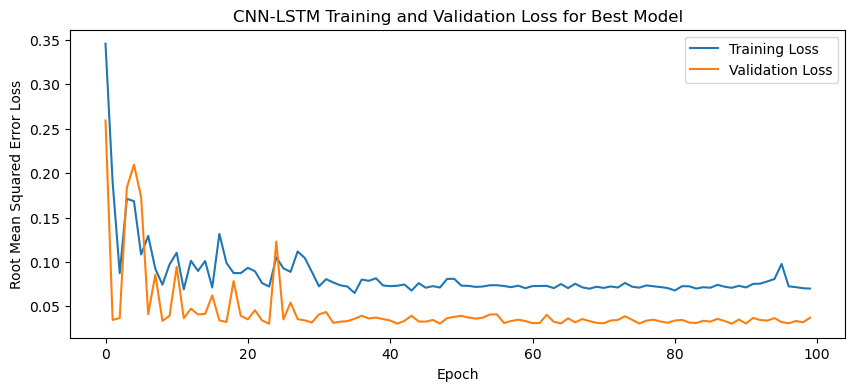

1/1 - 2s - loss: 0.1003 - 2s/epoch - 2s/step
Test Loss: 0.10028437525033951
Fold 2:
Epoch 1/100
19/19 [==============================] - 12s 67ms/step - loss: 0.4237 - val_loss: 0.0996
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2288 - val_loss: 0.0656
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1214 - val_loss: 0.0600
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1500 - val_loss: 0.0555
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1586 - val_loss: 0.0479
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1015 - val_loss: 0.0791
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1580 - val_loss: 0.0516
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1645 - val_loss: 0.1399
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1235 - val_loss: 0.1281
Epoch 10/100
19/19 [===

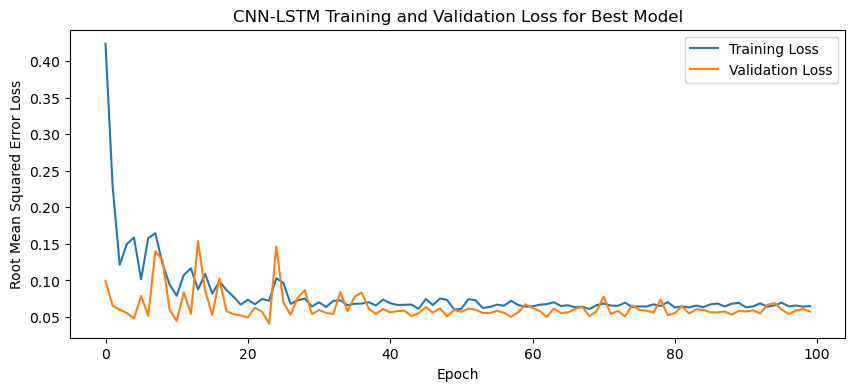

1/1 - 2s - loss: 0.1313 - 2s/epoch - 2s/step
Test Loss: 0.13125140964984894
Fold 3:
Epoch 1/100
19/19 [==============================] - 8s 152ms/step - loss: 0.3726 - val_loss: 0.7409
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.2016 - val_loss: 0.0822
Epoch 3/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1026 - val_loss: 0.1581
Epoch 4/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0880 - val_loss: 0.2179
Epoch 5/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1581 - val_loss: 0.2353
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1375 - val_loss: 0.2278
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1021 - val_loss: 0.0963
Epoch 8/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0997 - val_loss: 0.1042
Epoch 9/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0912 - val_loss: 0.0850
Epoch 10/100
19

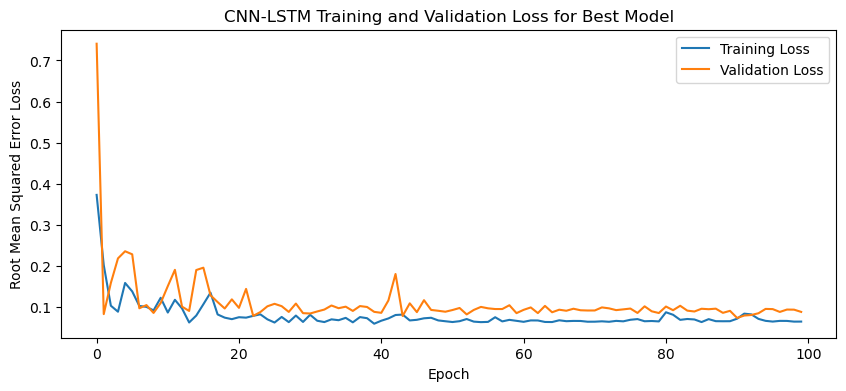

1/1 - 2s - loss: 0.1042 - 2s/epoch - 2s/step
Test Loss: 0.10421964526176453
Fold 4:
Epoch 1/100
20/20 [==============================] - 8s 147ms/step - loss: 0.4006 - val_loss: 0.1635
Epoch 2/100
20/20 [==============================] - 0s 15ms/step - loss: 0.1604 - val_loss: 0.0061
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1877 - val_loss: 0.0731
Epoch 4/100
20/20 [==============================] - 0s 15ms/step - loss: 0.2770 - val_loss: 0.3512
Epoch 5/100
20/20 [==============================] - 0s 15ms/step - loss: 0.1663 - val_loss: 0.2761
Epoch 6/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1829 - val_loss: 0.2190
Epoch 7/100
20/20 [==============================] - 0s 17ms/step - loss: 0.1512 - val_loss: 0.2489
Epoch 8/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1773 - val_loss: 0.0996
Epoch 9/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1124 - val_loss: 0.0068
Epoch 10/100
20

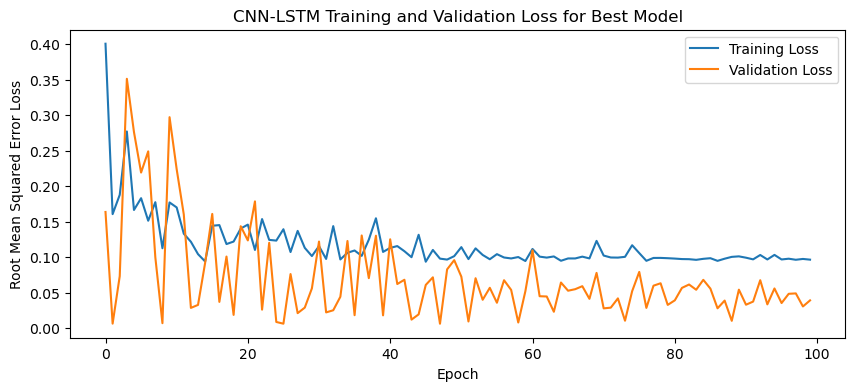

1/1 - 1s - loss: 0.1409 - 1s/epoch - 1s/step
Test Loss: 0.14085149765014648
Fold 5:
Epoch 1/100
19/19 [==============================] - 9s 70ms/step - loss: 0.3895 - val_loss: 0.4335
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.3223 - val_loss: 0.2258
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1605 - val_loss: 0.0552
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1868 - val_loss: 0.1607
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1126 - val_loss: 0.0654
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1066 - val_loss: 0.0578
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1018 - val_loss: 0.0956
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0809 - val_loss: 0.0610
Epoch 9/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1556 - val_loss: 0.0939
Epoch 10/100
19/19 [=

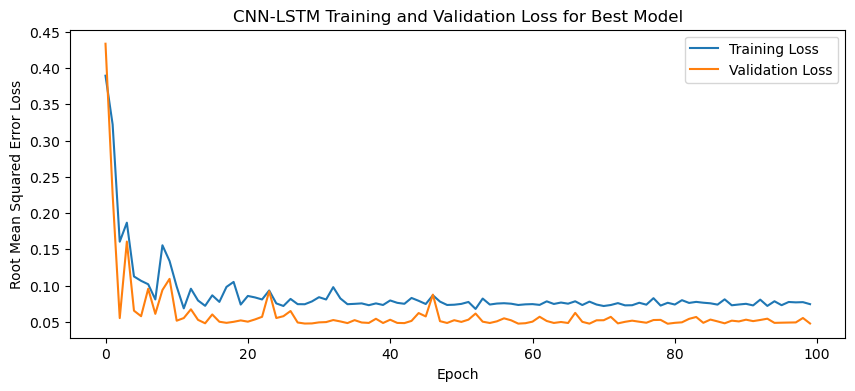

1/1 - 4s - loss: 0.0561 - 4s/epoch - 4s/step
Test Loss: 0.056130923330783844


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

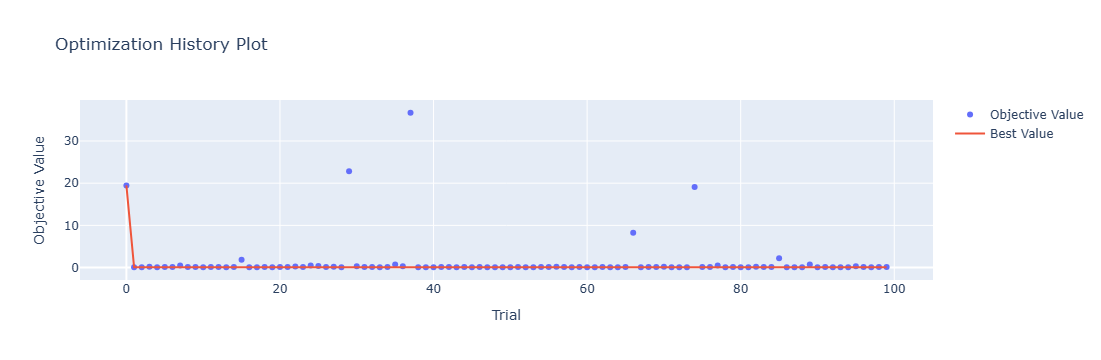

In [4]:
optuna.visualization.plot_optimization_history(study)

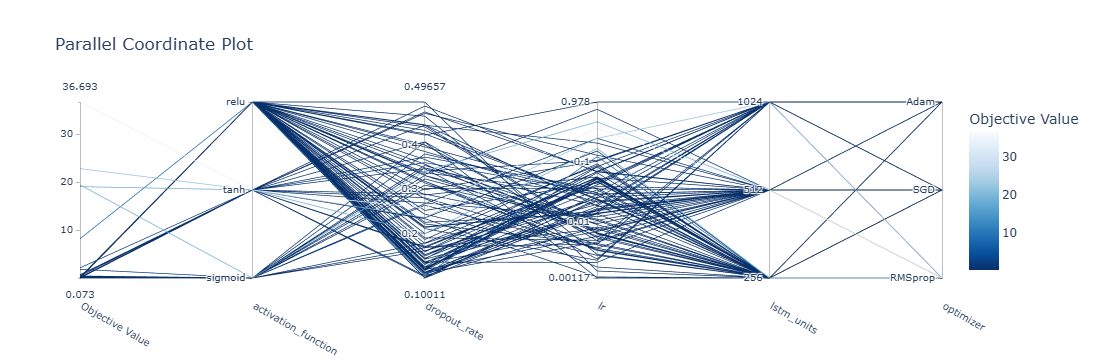

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

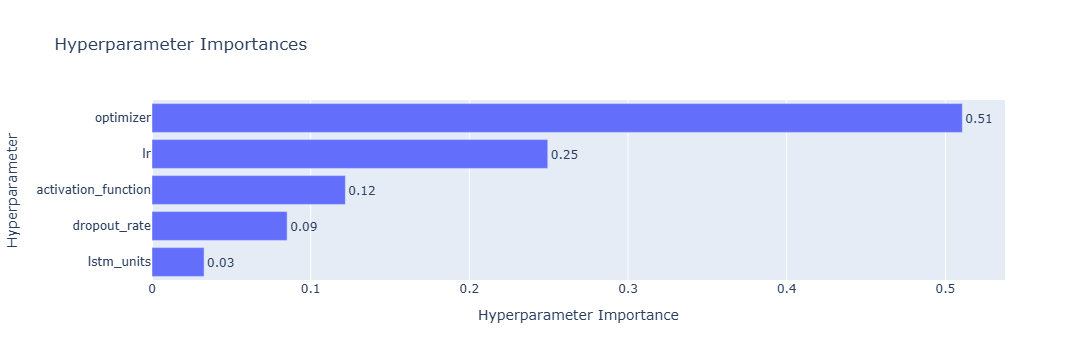

In [6]:
optuna.visualization.plot_param_importances(study)

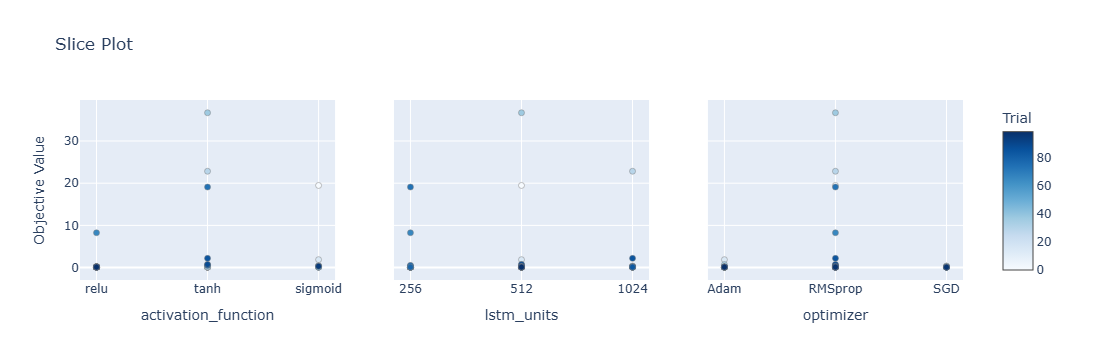

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

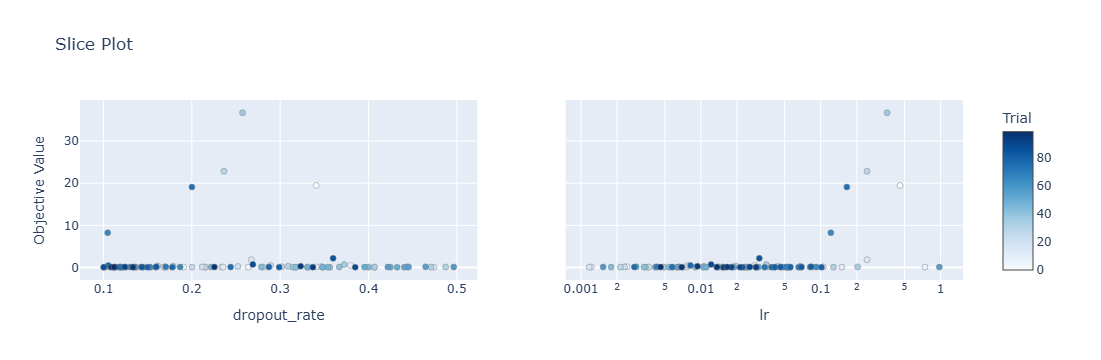

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 25s 298ms/step - loss: 0.3536 - accuracy: 0.0000e+00 - mae: 0.3536 - rmse: 0.3536 - mape: 83.0778 - pearson: nan - val_loss: 0.2176 - val_accuracy: 0.0000e+00 - val_mae: 0.2176 - val_rmse: 0.2176 - val_mape: 46.1069 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 34ms/step - loss: 0.2841 - accuracy: 0.0000e+00 - mae: 0.2841 - rmse: 0.2841 - mape: 61.4730 - pearson: nan - val_loss: 0.0796 - val_accuracy: 0.0000e+00 - val_mae: 0.0796 - val_rmse: 0.0796 - val_mape: 17.7536 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 38ms/step - loss: 0.1343 - accu

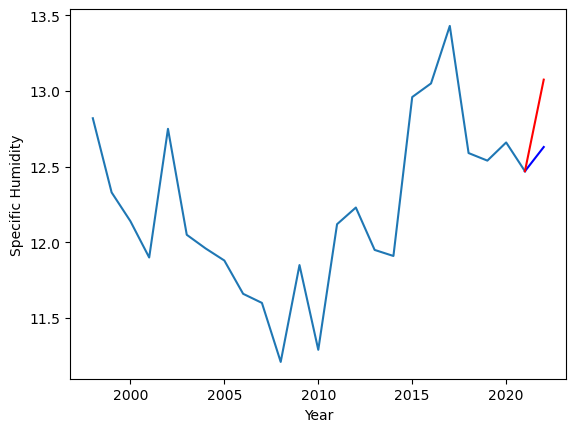

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.63		10.33		0.70


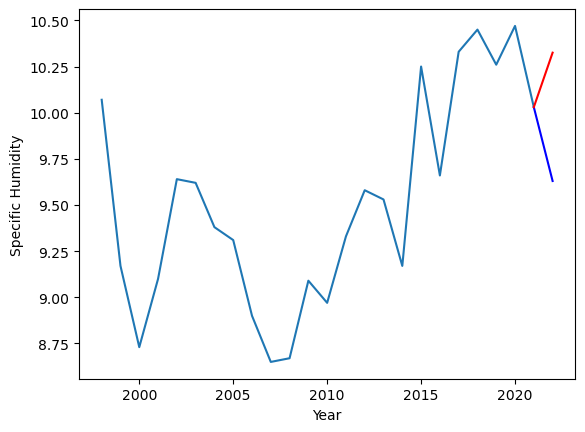

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.63  13.075094
1                1    9.63  10.325095


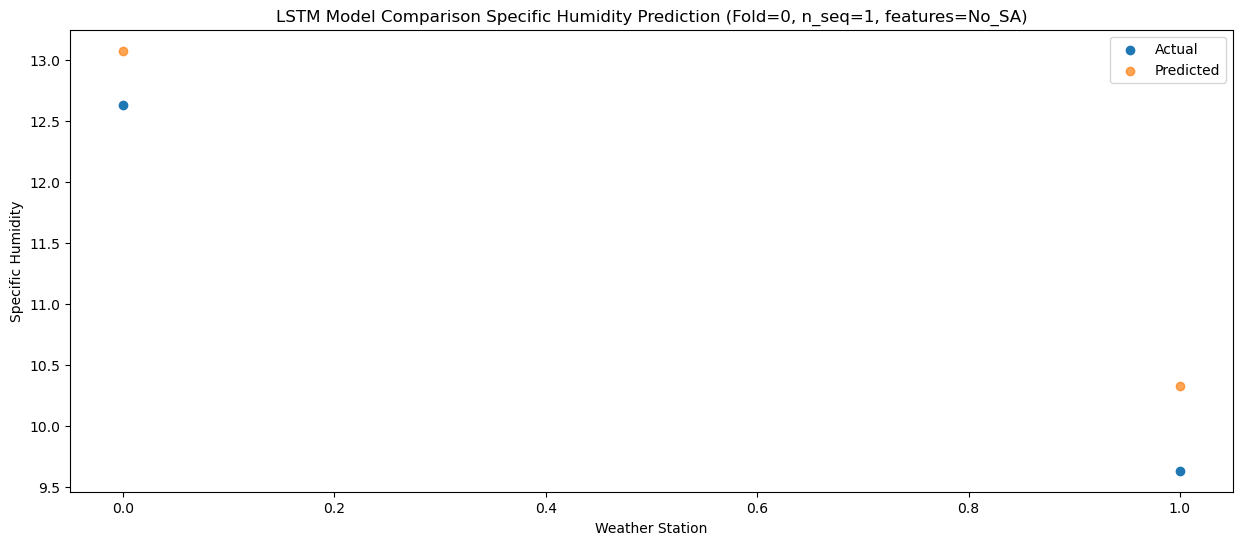

f, t:
[[12.63  9.63]]
[[13.07509378 10.32509539]]
Year at t+1:
t+1 SKRMSE: 0.583638
t+1 KRMSE: 0.583638
t+1 MAE: 0.570095
t+1 SKMAPE: 0.053711
t+1 R2_SCORE: 0.848608
t+1 KMAPE: 0.053711
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.130000
Metrics for this Fold:
SKRMSE: 0.583638
KRMSE: 0.583638
MAE: 0.570095
SKMAPE: 0.053711
R2_SCORE: 0.848608
KMAPE: 0.053711
PEARSON: 1.000000
AVERAGE ACTUAL: 11.130000
Model: "sequential_510"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1020 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1020 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1021 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1021 (Dropout)      (1, 256)       

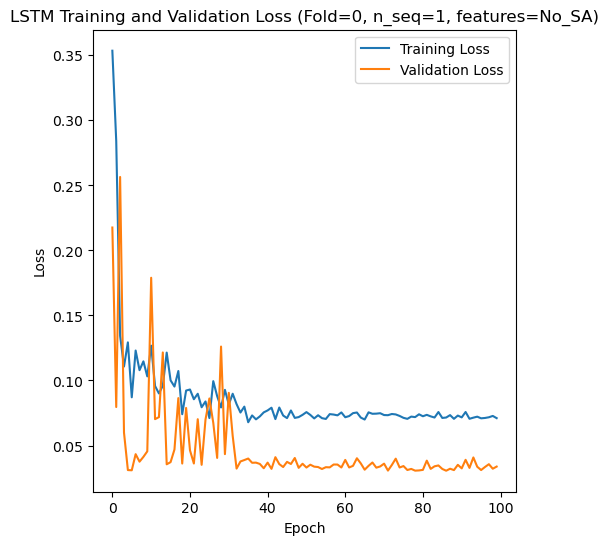

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 29s 396ms/step - loss: 0.3561 - accuracy: 0.0000e+00 - mae: 0.3561 - rmse: 0.3561 - mape: 81.8284 - pearson: nan - val_loss: 0.2666 - val_accuracy: 0.0000e+00 - val_mae: 0.2666 - val_rmse: 0.2666 - val_mape: 53.3652 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 104ms/step - loss: 0.1464 - accuracy: 0.0000e+00 - mae: 0.1464 - rmse: 0.1464 - mape: 32.4470 - pearson: nan - val_loss: 0.0881 - val_accuracy: 0.0000e+00 - val_mae: 0.0881 - val_rmse: 0.0881 - val_mape: 18.2517 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 90ms/step - loss: 0.1399 - acc

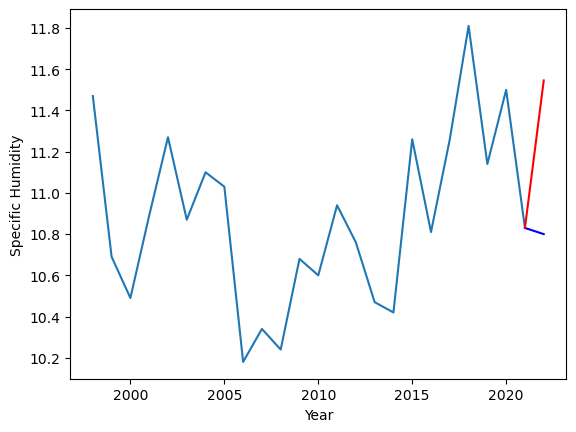

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		7.71		-0.36


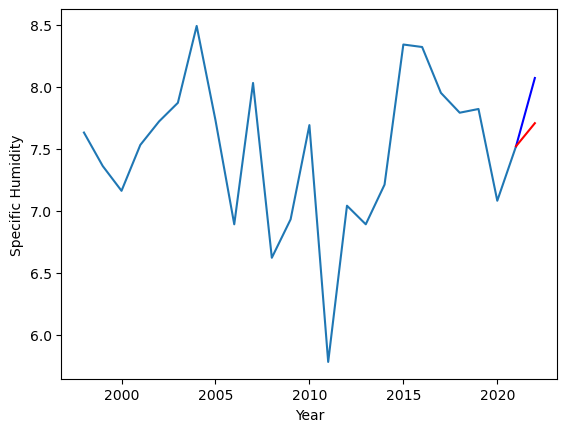

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.545560
1                1    8.07   7.705559


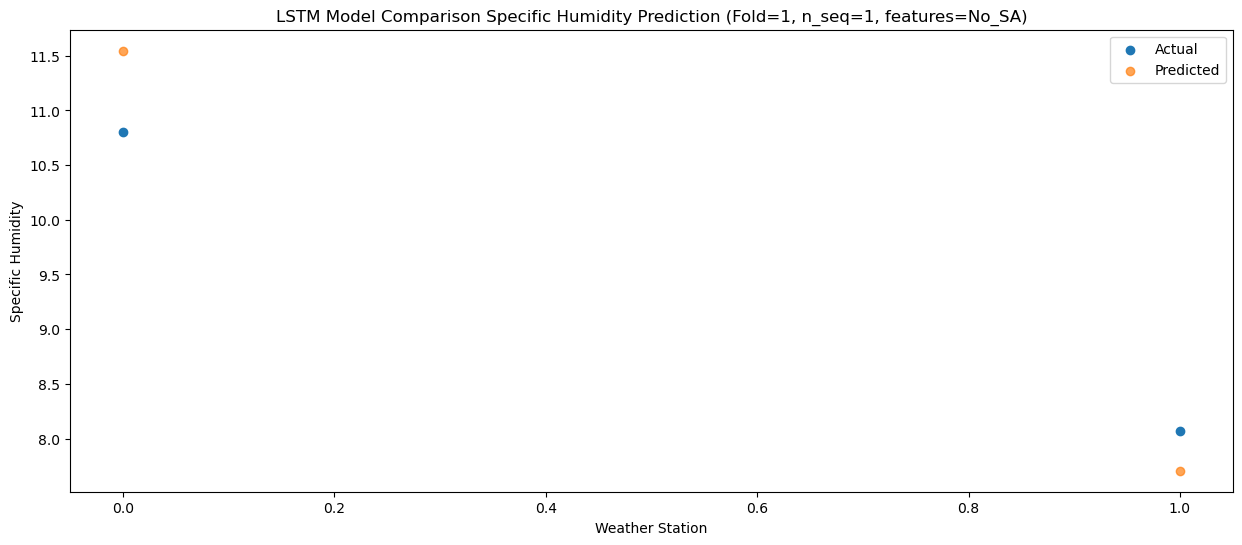

f, t:
[[10.8   8.07]]
[[11.54556004  7.7055595 ]]
Year at t+1:
t+1 SKRMSE: 0.586803
t+1 KRMSE: 0.586803
t+1 MAE: 0.555000
t+1 SKMAPE: 0.057097
t+1 R2_SCORE: 0.815192
t+1 KMAPE: 0.057097
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.435000
Metrics for this Fold:
SKRMSE: 0.586803
KRMSE: 0.586803
MAE: 0.555000
SKMAPE: 0.057097
R2_SCORE: 0.815192
KMAPE: 0.057097
PEARSON: 1.000000
AVERAGE ACTUAL: 9.435000
Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1022 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1022 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1023 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1023 (Dropout)      (1, 256)         

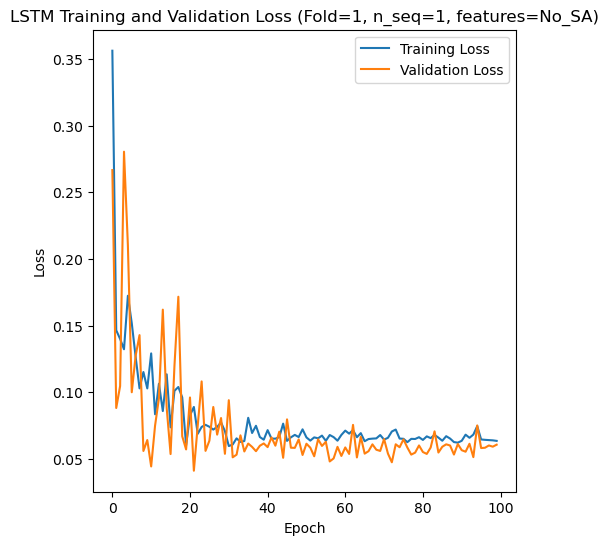

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 29s 393ms/step - loss: 0.3554 - accuracy: 0.0000e+00 - mae: 0.3554 - rmse: 0.3554 - mape: 82.4701 - pearson: nan - val_loss: 0.0772 - val_accuracy: 0.0000e+00 - val_mae: 0.0772 - val_rmse: 0.0772 - val_mape: 14.7695 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 72ms/step - loss: 0.1891 - accuracy: 0.0000e+00 - mae: 0.1891 - rmse: 0.1891 - mape: 42.6330 - pearson: nan - val_loss: 0.3498 - val_accuracy: 0.0000e+00 - val_mae: 0.3498 - val_rmse: 0.3498 - val_mape: 63.2713 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 66ms/step - loss: 0.1199 - accu

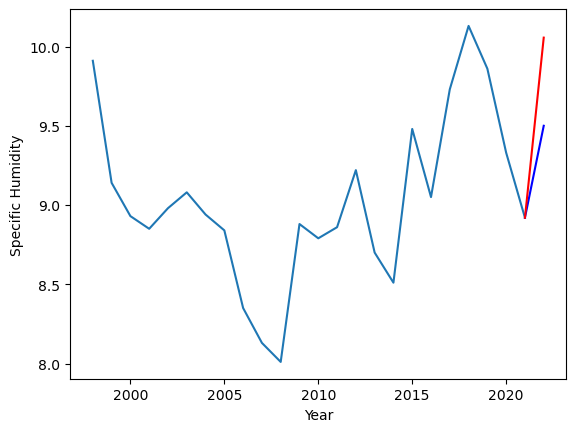

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.56		8.64		0.08


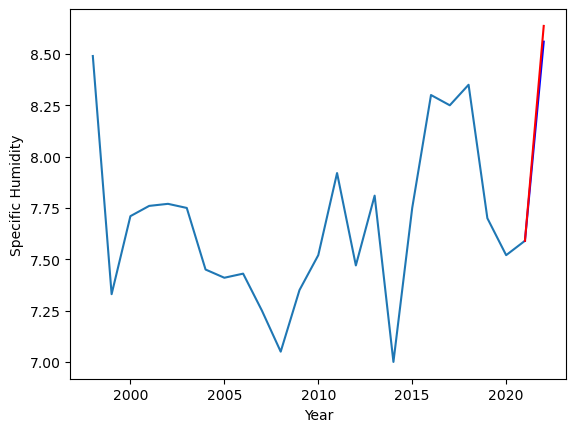

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.50  10.056199
1                1    8.56   8.636602


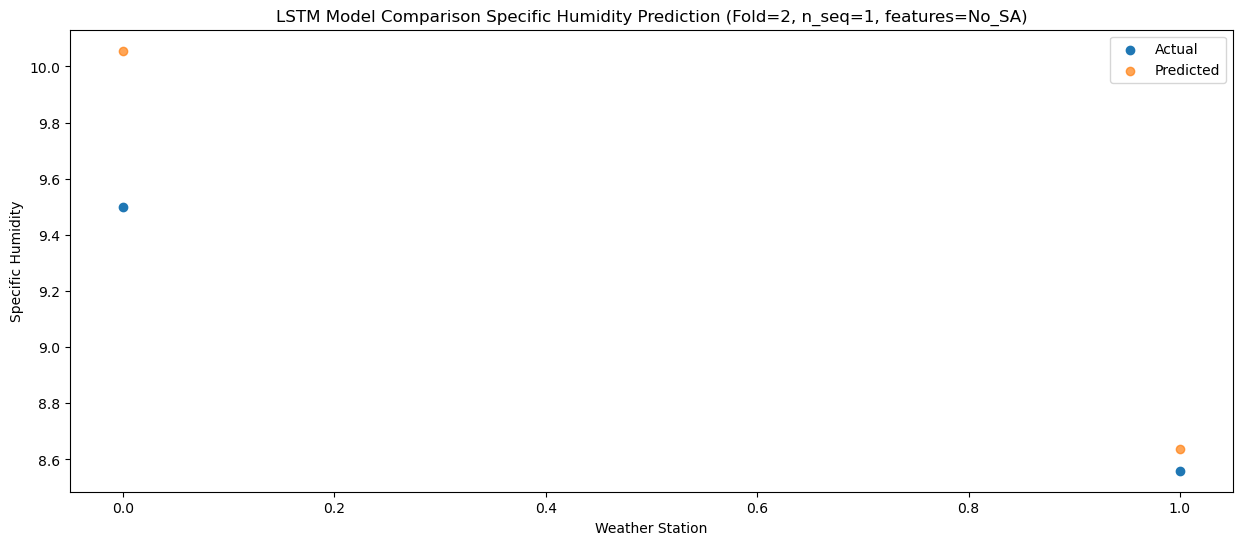

f, t:
[[9.5  8.56]]
[[10.05619949  8.63660195]]
Year at t+1:
t+1 SKRMSE: 0.397005
t+1 KRMSE: 0.397005
t+1 MAE: 0.316401
t+1 SKMAPE: 0.033748
t+1 R2_SCORE: 0.286497
t+1 KMAPE: 0.033748
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.030000
Metrics for this Fold:
SKRMSE: 0.397005
KRMSE: 0.397005
MAE: 0.316401
SKMAPE: 0.033748
R2_SCORE: 0.286497
KMAPE: 0.033748
PEARSON: 1.000000
AVERAGE ACTUAL: 9.030000
Model: "sequential_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1024 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1024 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1025 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1025 (Dropout)      (1, 256)           

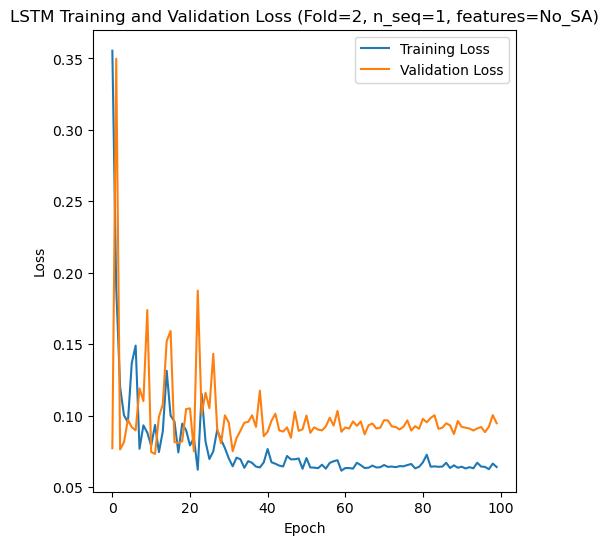

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 27s 292ms/step - loss: 0.4167 - accuracy: 0.0000e+00 - mae: 0.4167 - rmse: 0.4167 - mape: 62.7553 - pearson: nan - val_loss: 0.3057 - val_accuracy: 0.0000e+00 - val_mae: 0.3057 - val_rmse: 0.3057 - val_mape: 43.9268 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 0.3223 - accuracy: 0.0000e+00 - mae: 0.3223 - rmse: 0.3223 - mape: 49.0006 - pearson: nan - val_loss: 0.2421 - val_accuracy: 0.0000e+00 - val_mae: 0.2421 - val_rmse: 0.2421 - val_mape: 34.8067 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 1s 32ms/step - loss: 0.2116 - accuracy: 0.0000e+00 - mae: 0.2116 - rmse: 0.2116 - mape: 34.2

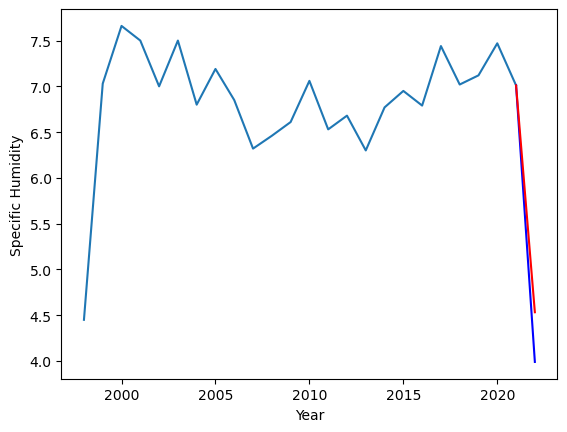

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.30		8.41		0.11


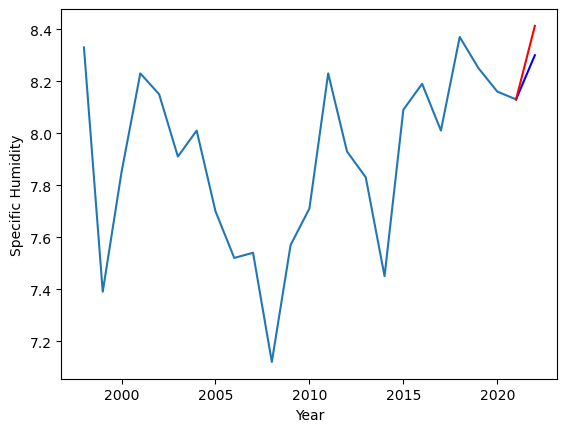

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    3.99   4.532605
1                1    8.30   8.412605


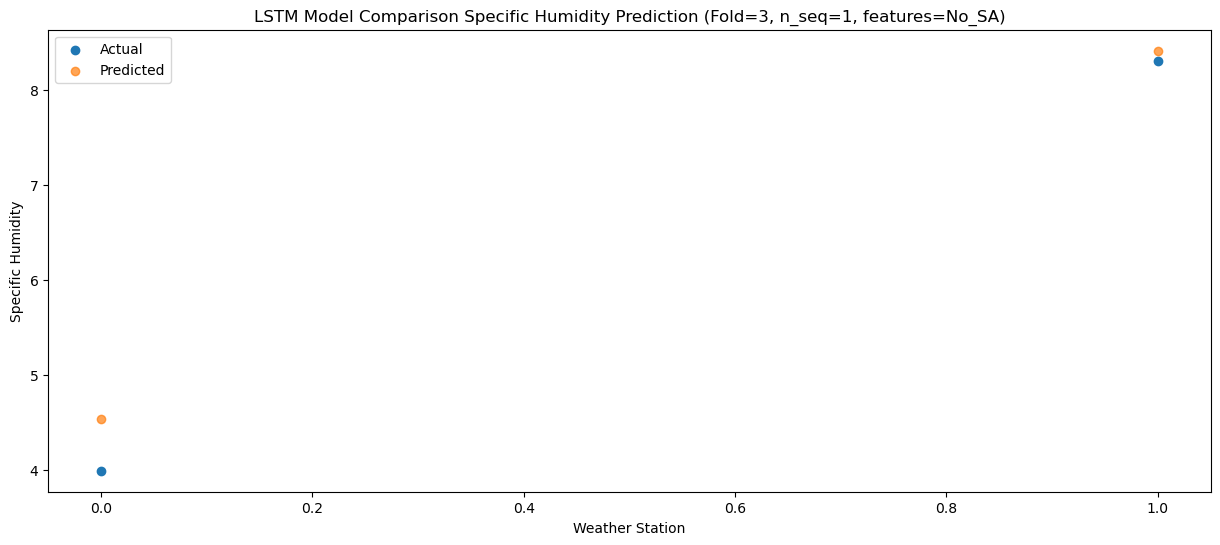

f, t:
[[3.99 8.3 ]]
[[4.53260525 8.41260525]]
Year at t+1:
t+1 SKRMSE: 0.391855
t+1 KRMSE: 0.391855
t+1 MAE: 0.327605
t+1 SKMAPE: 0.074779
t+1 R2_SCORE: 0.966936
t+1 KMAPE: 0.074779
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.145000
Metrics for this Fold:
SKRMSE: 0.391855
KRMSE: 0.391855
MAE: 0.327605
SKMAPE: 0.074779
R2_SCORE: 0.966936
KMAPE: 0.074779
PEARSON: 1.000000
AVERAGE ACTUAL: 6.145000
Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1026 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1026 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1027 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1027 (Dropout)      (1, 256)             

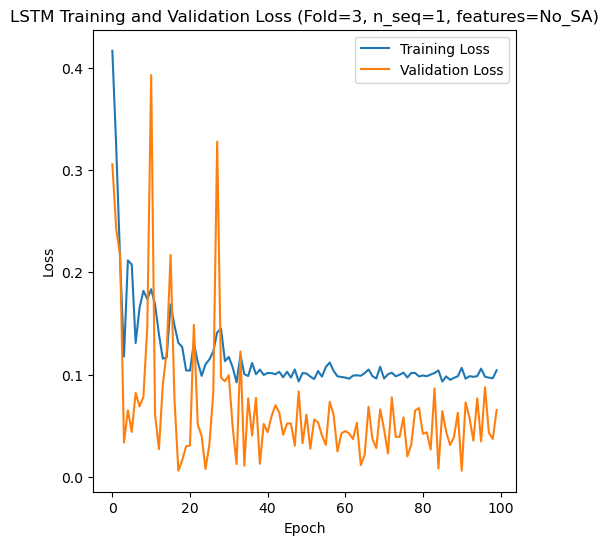

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 10s 110ms/step - loss: 0.3073 - accuracy: 0.0000e+00 - mae: 0.3073 - rmse: 0.3073 - mape: 68.3643 - pearson: nan - val_loss: 0.2124 - val_accuracy: 0.0000e+00 - val_mae: 0.2124 - val_rmse: 0.2124 - val_mape: 52.6497 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - mae: 0.1977 - rmse: 0.1977 - mape: 47.0459 - pearson: nan - val_loss: 0.1061 - val_accuracy: 0.0000e+00 - val_mae: 0.1061 - val_rmse: 0.1061 - val_mape: 27.4199 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1887 - accurac

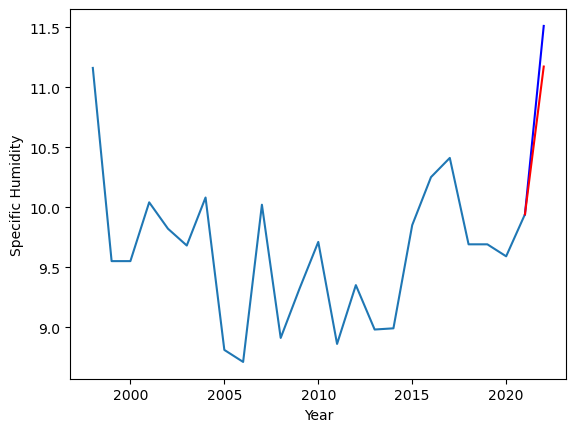

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.66		8.34		-0.32


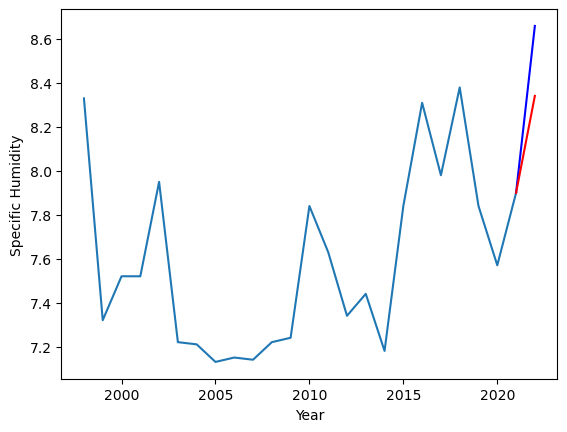

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.51  11.171398
1                1    8.66   8.341418


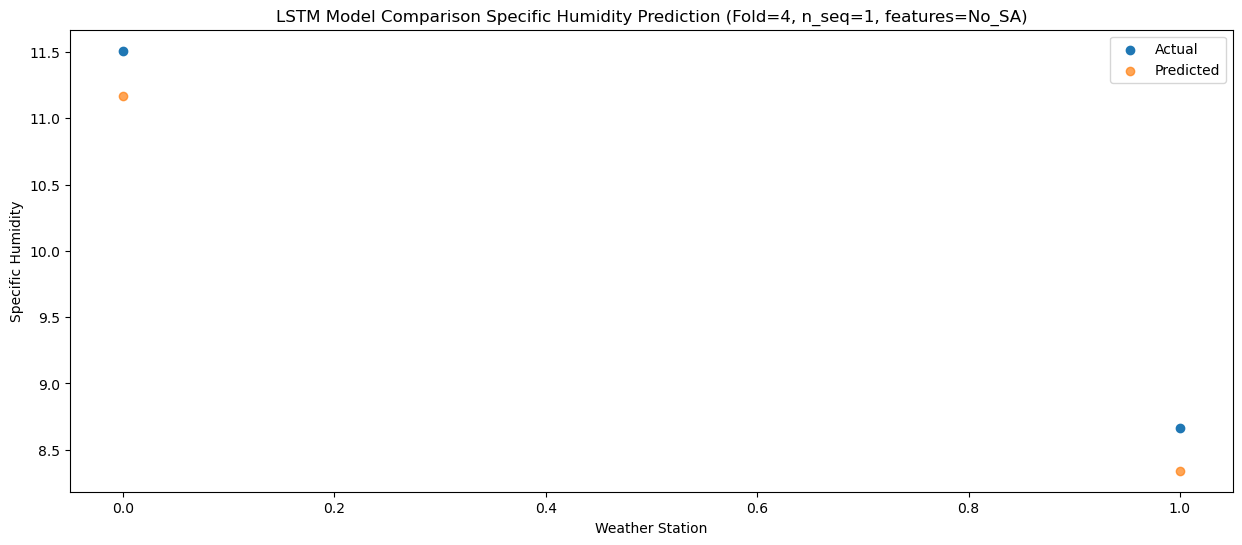

f, t:
[[11.51  8.66]]
[[11.17139827  8.34141837]]
Year at t+1:
t+1 SKRMSE: 0.328744
t+1 KRMSE: 0.328744
t+1 MAE: 0.328592
t+1 SKMAPE: 0.033103
t+1 R2_SCORE: 0.946779
t+1 KMAPE: 0.033103
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 10.085000
Metrics for this Fold:
SKRMSE: 0.328744
KRMSE: 0.328744
MAE: 0.328592
SKMAPE: 0.033103
R2_SCORE: 0.946779
KMAPE: 0.033103
PEARSON: 1.000000
AVERAGE ACTUAL: 10.085000
Model: "sequential_514"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1028 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1028 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1029 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1029 (Dropout)      (1, 256)       

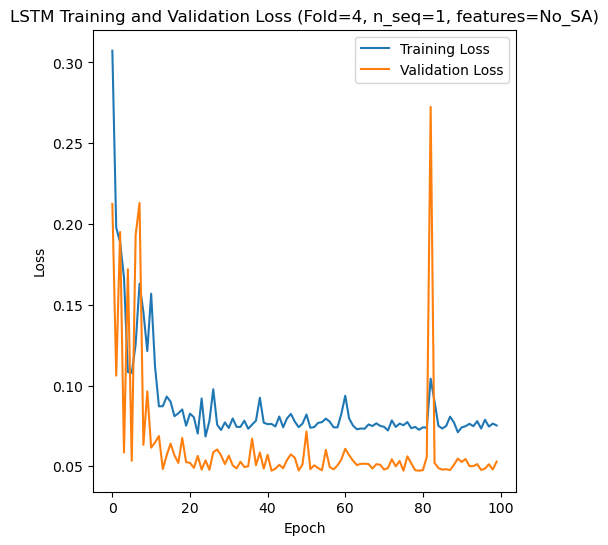

[[0.5836377645496116], [0.5868034827395605], [0.3970048713782989], [0.3918548199848358], [0.3287441156230104]]
[[array(0.58363776)], [array(0.58680348)], [array(0.39700487)], [array(0.39185482)], [array(0.32874412)]]
[[0.5700945878028874], [0.555000271946192], [0.31640071988105767], [0.32760525017976727], [0.32859168030321584]]
[[0.05371060159586567], [0.05709662537708415], [0.033748070295227604], [0.07477909419194584], [0.033102882402811167]]
[[0.8486075376851256], [0.8151922997194233], [0.28649675012177556], [0.9669359661187552], [0.9467786058200036]]
[[array(0.0537106)], [array(0.05709663)], [array(0.03374807)], [array(0.07477909)], [array(0.03310288)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[12.63  9.63 10.8   8.07  9.5   8.56  3.99  8.3  11.51  8.66]
[13.07509378 10.32509539 11.54556004  7.7055595  10.05619949  8.63660195
  4.53260525  8.41260525 11.17139827  8.34141837]
Accuracy Results:
RMSE for each fold:
[[0.5836377645496116], [0.5868034827395605], [

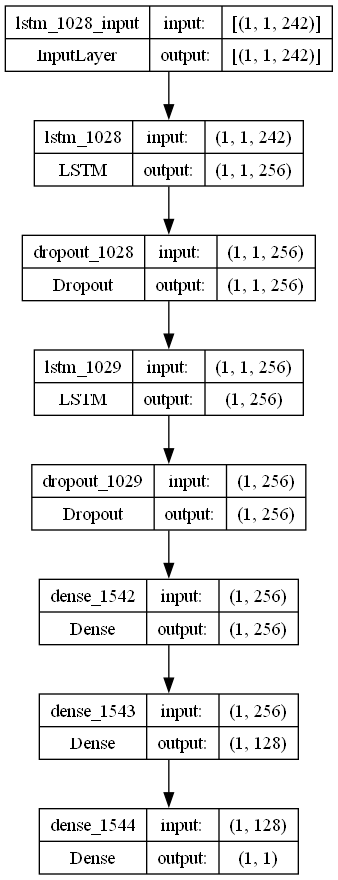

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.005773428515251549 
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.35634844108699765

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S1_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)